# Analiza nastrojów oparta na regułach

Jest to praktyczne podejście do analizy tekstu bez uczenia lub korzystania z modeli uczenia maszynowego. Wynikiem tego podejścia jest zestaw reguł, na podstawie których tekst jest oznaczony jako pozytywny/negatywny/neutralny.

https://www.analyticsvidhya.com/blog/2021/06/rule-based-sentiment-analysis-in-python/

In [16]:
import pandas as pd
import re
import numpy as np

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from afinn import Afinn

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
tweet2020 = pd.read_csv('tweet2020.csv')
tweet2021 = pd.read_csv('tweet2021.csv')

C:\Python39\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (0,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
tweet2020.head()

,TweetID,Text,UserID,likeCount,lang,hastags,coordinates,place,date,time
0,1344795096810622976,i can’t believe just 8 more hours and no more ...,1026350633035558912,12,en,NaN,NaN,NaN,2020-12-31,23:58
1,1344794960407703553,"Nothing is new about the year joor, today's Fr...",867172406829383682,1,en,['ExtraSpecial2021'],NaN,NaN,2020-12-31,23:57
2,1344794765833940992,Turned on ITV to see what they were putting on...,1301626062988812290,1,en,NaN,NaN,NaN,2020-12-31,23:57
3,1344794654663974912,115 new cases and 2 new deaths in Niger \n\n[2...,1236273574895329281,0,en,"['coronavirus', 'CoronaVirusUpdate', 'COVID19'...",NaN,NaN,2020-12-31,23:56
4,1344794530479034368,Imagine being in Italy peak covid and not gett...,556227476,5,en,NaN,NaN,NaN,2020-12-31,23:56


In [4]:
tweet2021.head()

,TweetID,Text,UserID,likeCount,lang,hastags,coordinates,place,date,time
0,1509680944877350915,"covid is over for 95% of people world wide , y...",1473294615109320711,0,en,['CovidIsOver'],NaN,NaN,2022-03-31,23:56
1,1509680414582980608,"Daniel Andrews quoted these exact words;\n ""Bu...",1464862641483137025,7,en,NaN,NaN,NaN,2022-03-31,23:53
2,1509680355392978947,"Greeting,people! Eating eggtarts is a essentia...",1429571873780637700,0,en,NaN,NaN,NaN,2022-03-31,23:53
3,1509679961074028552,"My 20yro daughter isnt well. Headaches, stoma...",940075218,0,en,NaN,NaN,NaN,2022-03-31,23:52
4,1509679696325263372,Prior to the #WarOnTigray the spread of COVID-...,1508134525246873602,0,en,"['WarOnTigray', 'TigrayGenocide']",NaN,NaN,2022-03-31,23:51


In [51]:
# funkcja ktora wyczysci tekst ze zbednych znacznikow
def clean(text):
    #usunie wszystkie znaki niealfanumeryczne, oprócz alfabetu (az) i cyfr (0-9). Znak ^ oznacza z wyjątkiem.
    text_without_symbols = re.sub("(@[A-Za-z0-9]+)|([^A-Za-z'’\t])|(\w+:\/\/\S+)", " ", text)
    regex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emotikony
        u"\U0001F300-\U0001F5FF"  # symbole i piktogramy
        u"\U0001F680-\U0001F6FF"  # symbole transportu i mapy
        u"\U0001F1E0-\U0001F1FF"  # flagi
                           "]+", flags = re.UNICODE)
    # spacja zamiast emotikonow/symboli
    text_without_pattern = re.sub(regex_pattern, ' ', text_without_symbols)
    
    #usuwa linki
    link = re.compile(r'(https?://)?(www\.)?(\w+\.)?(\w+)(\.\w+)(/.+)?')
    text_without_link = re.sub(link, ' ', text_without_pattern)
    
    #zmiana tekstu na male litery
    text_low = text_without_link.lower()
    return text_low

# Wstępne przetwarzanie danych

In [6]:
tweet2020['CleanedText'] = tweet2020['Text'].apply(clean)
tweet2020.head()

,TweetID,Text,UserID,likeCount,lang,hastags,coordinates,place,date,time,CleanedText
0,1344795096810622976,i can’t believe just 8 more hours and no more ...,1026350633035558912,12,en,NaN,NaN,NaN,2020-12-31,23:58,i can’t believe just more hours and no more ...
1,1344794960407703553,"Nothing is new about the year joor, today's Fr...",867172406829383682,1,en,['ExtraSpecial2021'],NaN,NaN,2020-12-31,23:57,nothing is new about the year joor today's fr...
2,1344794765833940992,Turned on ITV to see what they were putting on...,1301626062988812290,1,en,NaN,NaN,NaN,2020-12-31,23:57,turned on itv to see what they were putting on...
3,1344794654663974912,115 new cases and 2 new deaths in Niger \n\n[2...,1236273574895329281,0,en,"['coronavirus', 'CoronaVirusUpdate', 'COVID19'...",NaN,NaN,2020-12-31,23:56,new cases and new deaths in niger ...
4,1344794530479034368,Imagine being in Italy peak covid and not gett...,556227476,5,en,NaN,NaN,NaN,2020-12-31,23:56,imagine being in italy peak covid and not gett...


In [7]:
tweet2021['CleanedText'] = tweet2021['Text'].apply(clean)
tweet2021.head()

,TweetID,Text,UserID,likeCount,lang,hastags,coordinates,place,date,time,CleanedText
0,1509680944877350915,"covid is over for 95% of people world wide , y...",1473294615109320711,0,en,['CovidIsOver'],NaN,NaN,2022-03-31,23:56,covid is over for of people world wide y...
1,1509680414582980608,"Daniel Andrews quoted these exact words;\n ""Bu...",1464862641483137025,7,en,NaN,NaN,NaN,2022-03-31,23:53,daniel andrews quoted these exact words but...
2,1509680355392978947,"Greeting,people! Eating eggtarts is a essentia...",1429571873780637700,0,en,NaN,NaN,NaN,2022-03-31,23:53,greeting people eating eggtarts is a essentia...
3,1509679961074028552,"My 20yro daughter isnt well. Headaches, stoma...",940075218,0,en,NaN,NaN,NaN,2022-03-31,23:52,my yro daughter isnt well headaches stoma...
4,1509679696325263372,Prior to the #WarOnTigray the spread of COVID-...,1508134525246873602,0,en,"['WarOnTigray', 'TigrayGenocide']",NaN,NaN,2022-03-31,23:51,prior to the warontigray the spread of covid ...


Tokenizacja to proces dzielenia tekstu na mniejsze części. Może być wykonywany na poziomie zdań (tokenizacja zdań) lub słowa (tokenizacja słów).

In [8]:
tweet2020['Tokenize'] = tweet2020['CleanedText'].str.split()

In [9]:
tweet2020['Tokenize']

0          [i, can’t, believe, just, more, hours, and, no...
1          [nothing, is, new, about, the, year, joor, tod...
2          [turned, on, itv, to, see, what, they, were, p...
3          [new, cases, and, new, deaths, in, niger, gmt,...
4          [imagine, being, in, italy, peak, covid, and, ...
                                 ...                        
2465111    [i’ve, been, running, a, fever, ever, since, i...
2465112    [three, years, ago, today, our, month, old, so...
2465113    [yrs, they, won’t, write, my, file, right, cor...
2465114    [harry, or, joan, because, if, nice, it, is, n...
2465115    [so, i, just, got, diagnosed, with, the, coron...
Name: Tokenize, Length: 2465116, dtype: object

In [10]:
tweet2021['Tokenize'] = tweet2021['CleanedText'].str.split()

In [11]:
tweet2021['Tokenize']

0         [covid, is, over, for, of, people, world, wide...
1         [daniel, andrews, quoted, these, exact, words,...
2         [greeting, people, eating, eggtarts, is, a, es...
3         [my, yro, daughter, isnt, well, headaches, sto...
4         [prior, to, the, warontigray, the, spread, of,...
                                ...                        
417279    [wuhan, i, ate, a, fucking, rabid, bat, virus,...
417280            [ended, corona, virus, free, periodttttt]
417281                       [yay, corona, virus, is, gone]
417282            [oh, my, god, corona, virus, just, ended]
417283                   [so, is, corona, virus, gone, now]
Name: Tokenize, Length: 417284, dtype: object

Tagowanie części mowy (POS) to proces przekształcania każdego tokena w krotkę mającą postać (słowo, tag). Tagowanie POS jest niezbędne do zachowania kontekstu słowa i lematyzacji. Osiągnięto to za pomocą funkcji nltk pos_tag. Dodatkowo stworzeno słownik POS (zmienna pos_dict), ponieważ pos_tag mają postać 'ADJ', 'VERB', 'NOUN', 'ADV'. W kolejnej funkcji WordNetLemmatizer wymaga POS jako a, v, n, r.

Stopwords to słowa, które należy usunąć ze względu na bardzo małą przydatność informacji.

In [52]:
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

def tag_stop_pos(text):
    tags = pos_tag(text) #tagowanie
    newlist = []
    for word, tag in tags:
        if word not in set(stopwords.words('english')): #wykluczenie słów należących do stopwords
            newlist.append(tuple([word, pos_dict.get(tag[0])])) #stworzenie nowej listy, mapowanie z pos_tag na pos_dict
    return newlist

In [13]:
tweet2020['POS_tagged'] = tweet2020['Tokenize'].apply(tag_stop_pos)
tweet2020.head()

,TweetID,Text,UserID,likeCount,lang,hastags,coordinates,place,date,time,CleanedText,Tokenize,POS_tagged
0,1344795096810622976,i can’t believe just 8 more hours and no more ...,1026350633035558912,12,en,NaN,NaN,NaN,2020-12-31,23:58,i can’t believe just more hours and no more ...,"[i, can’t, believe, just, more, hours, and, no...","[(can’t, n), (believe, v), (hours, n), (corona..."
1,1344794960407703553,"Nothing is new about the year joor, today's Fr...",867172406829383682,1,en,['ExtraSpecial2021'],NaN,NaN,2020-12-31,23:57,nothing is new about the year joor today's fr...,"[nothing, is, new, about, the, year, joor, tod...","[(nothing, n), (new, a), (year, n), (joor, n),..."
2,1344794765833940992,Turned on ITV to see what they were putting on...,1301626062988812290,1,en,NaN,NaN,NaN,2020-12-31,23:57,turned on itv to see what they were putting on...,"[turned, on, itv, to, see, what, they, were, p...","[(turned, v), (itv, n), (see, v), (putting, v)..."
3,1344794654663974912,115 new cases and 2 new deaths in Niger \n\n[2...,1236273574895329281,0,en,"['coronavirus', 'CoronaVirusUpdate', 'COVID19'...",NaN,NaN,2020-12-31,23:56,new cases and new deaths in niger ...,"[new, cases, and, new, deaths, in, niger, gmt,...","[(new, a), (cases, n), (new, a), (deaths, n), ..."
4,1344794530479034368,Imagine being in Italy peak covid and not gett...,556227476,5,en,NaN,NaN,NaN,2020-12-31,23:56,imagine being in italy peak covid and not gett...,"[imagine, being, in, italy, peak, covid, and, ...","[(imagine, n), (italy, a), (peak, n), (covid, ..."


In [14]:
tweet2021['POS_tagged'] = tweet2021['Tokenize'].apply(tag_stop_pos)
tweet2021.head()

,TweetID,Text,UserID,likeCount,lang,hastags,coordinates,place,date,time,CleanedText,Tokenize,POS_tagged
0,1509680944877350915,"covid is over for 95% of people world wide , y...",1473294615109320711,0,en,['CovidIsOver'],NaN,NaN,2022-03-31,23:56,covid is over for of people world wide y...,"[covid, is, over, for, of, people, world, wide...","[(covid, n), (people, n), (world, n), (wide, a..."
1,1509680414582980608,"Daniel Andrews quoted these exact words;\n ""Bu...",1464862641483137025,7,en,NaN,NaN,NaN,2022-03-31,23:53,daniel andrews quoted these exact words but...,"[daniel, andrews, quoted, these, exact, words,...","[(daniel, n), (andrews, n), (quoted, v), (exac..."
2,1509680355392978947,"Greeting,people! Eating eggtarts is a essentia...",1429571873780637700,0,en,NaN,NaN,NaN,2022-03-31,23:53,greeting people eating eggtarts is a essentia...,"[greeting, people, eating, eggtarts, is, a, es...","[(greeting, v), (people, n), (eating, v), (egg..."
3,1509679961074028552,"My 20yro daughter isnt well. Headaches, stoma...",940075218,0,en,NaN,NaN,NaN,2022-03-31,23:52,my yro daughter isnt well headaches stoma...,"[my, yro, daughter, isnt, well, headaches, sto...","[(yro, n), (daughter, n), (isnt, n), (well, r)..."
4,1509679696325263372,Prior to the #WarOnTigray the spread of COVID-...,1508134525246873602,0,en,"['WarOnTigray', 'TigrayGenocide']",NaN,NaN,2022-03-31,23:51,prior to the warontigray the spread of covid ...,"[prior, to, the, warontigray, the, spread, of,...","[(prior, r), (warontigray, n), (spread, n), (c..."


In [53]:
#Lematyzacja - uzyskanie słowa rdzennego
wordnet_lemmatizer = WordNetLemmatizer()

#podaje lemat dla każdego słowa w pos_tag na podstawie pozycji tego słowa 
def lemmatize(pos_data):
    lemma_tweet = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_tweet = lemma_tweet + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_tweet = lemma_tweet + " " + lemma
    return lemma_tweet

In [16]:
tweet2020['Lemma'] = tweet2020['POS_tagged'].apply(lemmatize)
tweet2020.head()

,TweetID,Text,UserID,likeCount,lang,hastags,coordinates,place,date,time,CleanedText,Tokenize,POS_tagged,Lemma
0,1344795096810622976,i can’t believe just 8 more hours and no more ...,1026350633035558912,12,en,NaN,NaN,NaN,2020-12-31,23:58,i can’t believe just more hours and no more ...,"[i, can’t, believe, just, more, hours, and, no...","[(can’t, n), (believe, v), (hours, n), (corona...",can’t believe hour corona virus it’s crazy year
1,1344794960407703553,"Nothing is new about the year joor, today's Fr...",867172406829383682,1,en,['ExtraSpecial2021'],NaN,NaN,2020-12-31,23:57,nothing is new about the year joor today's fr...,"[nothing, is, new, about, the, year, joor, tod...","[(nothing, n), (new, a), (year, n), (joor, n),...",nothing new year joor today's friday corona ...
2,1344794765833940992,Turned on ITV to see what they were putting on...,1301626062988812290,1,en,NaN,NaN,NaN,2020-12-31,23:57,turned on itv to see what they were putting on...,"[turned, on, itv, to, see, what, they, were, p...","[(turned, v), (itv, n), (see, v), (putting, v)...",turn itv see put telly new year fuck news te...
3,1344794654663974912,115 new cases and 2 new deaths in Niger \n\n[2...,1236273574895329281,0,en,"['coronavirus', 'CoronaVirusUpdate', 'COVID19'...",NaN,NaN,2020-12-31,23:56,new cases and new deaths in niger ...,"[new, cases, and, new, deaths, in, niger, gmt,...","[(new, a), (cases, n), (new, a), (deaths, n), ...",new case new death niger gmt coronavirus cor...
4,1344794530479034368,Imagine being in Italy peak covid and not gett...,556227476,5,en,NaN,NaN,NaN,2020-12-31,23:56,imagine being in italy peak covid and not gett...,"[imagine, being, in, italy, peak, covid, and, ...","[(imagine, n), (italy, a), (peak, n), (covid, ...",imagine italy peak covid get virus day new y...


In [17]:
tweet2021['Lemma'] = tweet2021['POS_tagged'].apply(lemmatize)
tweet2021.head()

,TweetID,Text,UserID,likeCount,lang,hastags,coordinates,place,date,time,CleanedText,Tokenize,POS_tagged,Lemma
0,1509680944877350915,"covid is over for 95% of people world wide , y...",1473294615109320711,0,en,['CovidIsOver'],NaN,NaN,2022-03-31,23:56,covid is over for of people world wide y...,"[covid, is, over, for, of, people, world, wide...","[(covid, n), (people, n), (world, n), (wide, a...",covid people world wide stay home covid frea...
1,1509680414582980608,"Daniel Andrews quoted these exact words;\n ""Bu...",1464862641483137025,7,en,NaN,NaN,NaN,2022-03-31,23:53,daniel andrews quoted these exact words but...,"[daniel, andrews, quoted, these, exact, words,...","[(daniel, n), (andrews, n), (quoted, v), (exac...",daniel andrew quote exact word three dos pre...
2,1509680355392978947,"Greeting,people! Eating eggtarts is a essentia...",1429571873780637700,0,en,NaN,NaN,NaN,2022-03-31,23:53,greeting people eating eggtarts is a essentia...,"[greeting, people, eating, eggtarts, is, a, es...","[(greeting, v), (people, n), (eating, v), (egg...",greet people eat eggtarts essential activity...
3,1509679961074028552,"My 20yro daughter isnt well. Headaches, stoma...",940075218,0,en,NaN,NaN,NaN,2022-03-31,23:52,my yro daughter isnt well headaches stoma...,"[my, yro, daughter, isnt, well, headaches, sto...","[(yro, n), (daughter, n), (isnt, n), (well, r)...",yro daughter isnt well headaches stomach cra...
4,1509679696325263372,Prior to the #WarOnTigray the spread of COVID-...,1508134525246873602,0,en,"['WarOnTigray', 'TigrayGenocide']",NaN,NaN,2022-03-31,23:51,prior to the warontigray the spread of covid ...,"[prior, to, the, warontigray, the, spread, of,...","[(prior, r), (warontigray, n), (spread, n), (c...",prior warontigray spread covid region less s...


# TextBlob

TextBlob to biblioteka Pythona do przetwarzania danych tekstowych. Zapewnia spójny interfejs API do zagłębiania się w typowe zadania przetwarzania języka naturalnego (NLP), takie jak tagowanie części mowy, wyodrębnianie fraz rzeczownikowych, analiza sentymentu.

In [54]:
#oblicza polaryzacje - wartości wahają się od -1 do 1 (1 oznacza pozytywny, 0 neutralny, -1 negatywny)
def TextBlob_Polarity(text):
    return TextBlob(text).sentiment.polarity

def TextBlob_analysis(score):
    if score < 0:
        return 'Negative'
    elif score > 0:
        return 'Positive'
    else:
        return 'Neutral'

In [19]:
tweet2020['Textblob_Polarity'] = tweet2020['Lemma'].apply(TextBlob_Polarity) 
tweet2020['Textblob_Analysis'] = tweet2020['Textblob_Polarity'].apply(TextBlob_analysis)
tweet2020.head()

,TweetID,Text,UserID,likeCount,lang,hastags,coordinates,place,date,time,CleanedText,Tokenize,POS_tagged,Lemma,Textblob_Polarity,Textblob_Analysis
0,1344795096810622976,i can’t believe just 8 more hours and no more ...,1026350633035558912,12,en,NaN,NaN,NaN,2020-12-31,23:58,i can’t believe just more hours and no more ...,"[i, can’t, believe, just, more, hours, and, no...","[(can’t, n), (believe, v), (hours, n), (corona...",can’t believe hour corona virus it’s crazy year,-0.600000,Negative
1,1344794960407703553,"Nothing is new about the year joor, today's Fr...",867172406829383682,1,en,['ExtraSpecial2021'],NaN,NaN,2020-12-31,23:57,nothing is new about the year joor today's fr...,"[nothing, is, new, about, the, year, joor, tod...","[(nothing, n), (new, a), (year, n), (joor, n),...",nothing new year joor today's friday corona ...,0.232121,Positive
2,1344794765833940992,Turned on ITV to see what they were putting on...,1301626062988812290,1,en,NaN,NaN,NaN,2020-12-31,23:57,turned on itv to see what they were putting on...,"[turned, on, itv, to, see, what, they, were, p...","[(turned, v), (itv, n), (see, v), (putting, v)...",turn itv see put telly new year fuck news te...,-0.112727,Negative
3,1344794654663974912,115 new cases and 2 new deaths in Niger \n\n[2...,1236273574895329281,0,en,"['coronavirus', 'CoronaVirusUpdate', 'COVID19'...",NaN,NaN,2020-12-31,23:56,new cases and new deaths in niger ...,"[new, cases, and, new, deaths, in, niger, gmt,...","[(new, a), (cases, n), (new, a), (deaths, n), ...",new case new death niger gmt coronavirus cor...,0.136364,Positive
4,1344794530479034368,Imagine being in Italy peak covid and not gett...,556227476,5,en,NaN,NaN,NaN,2020-12-31,23:56,imagine being in italy peak covid and not gett...,"[imagine, being, in, italy, peak, covid, and, ...","[(imagine, n), (italy, a), (peak, n), (covid, ...",imagine italy peak covid get virus day new y...,0.136364,Positive


In [20]:
tweet2021['Textblob_Polarity'] = tweet2021['Lemma'].apply(TextBlob_Polarity) 
tweet2021['Textblob_Analysis'] = tweet2021['Textblob_Polarity'].apply(TextBlob_analysis)
tweet2021.head()

,TweetID,Text,UserID,likeCount,lang,hastags,coordinates,place,date,time,CleanedText,Tokenize,POS_tagged,Lemma,Textblob_Polarity,Textblob_Analysis
0,1509680944877350915,"covid is over for 95% of people world wide , y...",1473294615109320711,0,en,['CovidIsOver'],NaN,NaN,2022-03-31,23:56,covid is over for of people world wide y...,"[covid, is, over, for, of, people, world, wide...","[(covid, n), (people, n), (world, n), (wide, a...",covid people world wide stay home covid frea...,0.066667,Positive
1,1509680414582980608,"Daniel Andrews quoted these exact words;\n ""Bu...",1464862641483137025,7,en,NaN,NaN,NaN,2022-03-31,23:53,daniel andrews quoted these exact words but...,"[daniel, andrews, quoted, these, exact, words,...","[(daniel, n), (andrews, n), (quoted, v), (exac...",daniel andrew quote exact word three dos pre...,-0.145833,Negative
2,1509680355392978947,"Greeting,people! Eating eggtarts is a essentia...",1429571873780637700,0,en,NaN,NaN,NaN,2022-03-31,23:53,greeting people eating eggtarts is a essentia...,"[greeting, people, eating, eggtarts, is, a, es...","[(greeting, v), (people, n), (eating, v), (egg...",greet people eat eggtarts essential activity...,-0.378571,Negative
3,1509679961074028552,"My 20yro daughter isnt well. Headaches, stoma...",940075218,0,en,NaN,NaN,NaN,2022-03-31,23:52,my yro daughter isnt well headaches stoma...,"[my, yro, daughter, isnt, well, headaches, sto...","[(yro, n), (daughter, n), (isnt, n), (well, r)...",yro daughter isnt well headaches stomach cra...,0.165000,Positive
4,1509679696325263372,Prior to the #WarOnTigray the spread of COVID-...,1508134525246873602,0,en,"['WarOnTigray', 'TigrayGenocide']",NaN,NaN,2022-03-31,23:51,prior to the warontigray the spread of covid ...,"[prior, to, the, warontigray, the, spread, of,...","[(prior, r), (warontigray, n), (spread, n), (c...",prior warontigray spread covid region less s...,-0.031723,Negative


In [6]:
textblob_counts2020 = tweet2020.Textblob_Analysis.value_counts()
textblob_counts2020

Positive    989539
Neutral     752083
Negative    723494
Name: Textblob_Analysis, dtype: int64

In [7]:
#obliczenie liczby pozytywnych, negatywnych i neutralnych tweetów
textblob_counts2021 = tweet2021.Textblob_Analysis.value_counts()
textblob_counts2021

Positive    186554
Negative    131628
Neutral      99102
Name: Textblob_Analysis, dtype: int64

# Sentyment Vadera

Sentyment Vadera narzędzie do analizy nastrojów oparte na leksykonie i regułach, które jest specjalnie dostosowane do nastrojów wyrażanych w mediach społecznościowych. Wykorzystuje listę cech leksykalnych, które są oznaczone jako pozytywne lub negatywne zgodnie z ich orientacją semantyczną, aby obliczyć sentyment tekstu.   

Sentyment Vadera zwraca prawdopodobieństwo, że dane zdanie wejściowe będzie pozytywne, negatywne i neutralne

In [55]:
analyzer = SentimentIntensityAnalyzer()

def vader_Sentiment(text):
    vs = analyzer.polarity_scores(text)
    return vs['compound']

def vader_Analysis(compound):
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05 :
        return 'Negative'
    else:
        return 'Neutral'

In [24]:
tweet2020['Vader_Sentiment'] = tweet2020['Lemma'].apply(vader_Sentiment)
tweet2020['Vader_Analysis'] = tweet2020['Vader_Sentiment'].apply(vader_Analysis)
tweet2020.head()

,TweetID,Text,UserID,likeCount,lang,hastags,coordinates,place,date,time,CleanedText,Tokenize,POS_tagged,Lemma,Textblob_Polarity,Textblob_Analysis,Vader_Sentiment,Vader_Analysis
0,1344795096810622976,i can’t believe just 8 more hours and no more ...,1026350633035558912,12,en,NaN,NaN,NaN,2020-12-31,23:58,i can’t believe just more hours and no more ...,"[i, can’t, believe, just, more, hours, and, no...","[(can’t, n), (believe, v), (hours, n), (corona...",can’t believe hour corona virus it’s crazy year,-0.600000,Negative,-0.3400,Negative
1,1344794960407703553,"Nothing is new about the year joor, today's Fr...",867172406829383682,1,en,['ExtraSpecial2021'],NaN,NaN,2020-12-31,23:57,nothing is new about the year joor today's fr...,"[nothing, is, new, about, the, year, joor, tod...","[(nothing, n), (new, a), (year, n), (joor, n),...",nothing new year joor today's friday corona ...,0.232121,Positive,0.5106,Positive
2,1344794765833940992,Turned on ITV to see what they were putting on...,1301626062988812290,1,en,NaN,NaN,NaN,2020-12-31,23:57,turned on itv to see what they were putting on...,"[turned, on, itv, to, see, what, they, were, p...","[(turned, v), (itv, n), (see, v), (putting, v)...",turn itv see put telly new year fuck news te...,-0.112727,Negative,-0.7351,Negative
3,1344794654663974912,115 new cases and 2 new deaths in Niger \n\n[2...,1236273574895329281,0,en,"['coronavirus', 'CoronaVirusUpdate', 'COVID19'...",NaN,NaN,2020-12-31,23:56,new cases and new deaths in niger ...,"[new, cases, and, new, deaths, in, niger, gmt,...","[(new, a), (cases, n), (new, a), (deaths, n), ...",new case new death niger gmt coronavirus cor...,0.136364,Positive,-0.5994,Negative
4,1344794530479034368,Imagine being in Italy peak covid and not gett...,556227476,5,en,NaN,NaN,NaN,2020-12-31,23:56,imagine being in italy peak covid and not gett...,"[imagine, being, in, italy, peak, covid, and, ...","[(imagine, n), (italy, a), (peak, n), (covid, ...",imagine italy peak covid get virus day new y...,0.136364,Positive,0.0000,Neutral


In [25]:
tweet2021['Vader_Sentiment'] = tweet2021['Lemma'].apply(vader_Sentiment)
tweet2021['Vader_Analysis'] = tweet2021['Vader_Sentiment'].apply(vader_Analysis)
tweet2021.head()

,TweetID,Text,UserID,likeCount,lang,hastags,coordinates,place,date,time,CleanedText,Tokenize,POS_tagged,Lemma,Textblob_Polarity,Textblob_Analysis,Vader_Sentiment,Vader_Analysis
0,1509680944877350915,"covid is over for 95% of people world wide , y...",1473294615109320711,0,en,['CovidIsOver'],NaN,NaN,2022-03-31,23:56,covid is over for of people world wide y...,"[covid, is, over, for, of, people, world, wide...","[(covid, n), (people, n), (world, n), (wide, a...",covid people world wide stay home covid frea...,0.066667,Positive,-0.4404,Negative
1,1509680414582980608,"Daniel Andrews quoted these exact words;\n ""Bu...",1464862641483137025,7,en,NaN,NaN,NaN,2022-03-31,23:53,daniel andrews quoted these exact words but...,"[daniel, andrews, quoted, these, exact, words,...","[(daniel, n), (andrews, n), (quoted, v), (exac...",daniel andrew quote exact word three dos pre...,-0.145833,Negative,-0.8658,Negative
2,1509680355392978947,"Greeting,people! Eating eggtarts is a essentia...",1429571873780637700,0,en,NaN,NaN,NaN,2022-03-31,23:53,greeting people eating eggtarts is a essentia...,"[greeting, people, eating, eggtarts, is, a, es...","[(greeting, v), (people, n), (eating, v), (egg...",greet people eat eggtarts essential activity...,-0.378571,Negative,0.4588,Positive
3,1509679961074028552,"My 20yro daughter isnt well. Headaches, stoma...",940075218,0,en,NaN,NaN,NaN,2022-03-31,23:52,my yro daughter isnt well headaches stoma...,"[my, yro, daughter, isnt, well, headaches, sto...","[(yro, n), (daughter, n), (isnt, n), (well, r)...",yro daughter isnt well headaches stomach cra...,0.165000,Positive,-0.8234,Negative
4,1509679696325263372,Prior to the #WarOnTigray the spread of COVID-...,1508134525246873602,0,en,"['WarOnTigray', 'TigrayGenocide']",NaN,NaN,2022-03-31,23:51,prior to the warontigray the spread of covid ...,"[prior, to, the, warontigray, the, spread, of,...","[(prior, r), (warontigray, n), (spread, n), (c...",prior warontigray spread covid region less s...,-0.031723,Negative,0.3818,Positive


In [4]:
vader_counts2020 = tweet2020.Vader_Analysis.value_counts()
vader_counts2020

Negative    1106603
Positive     913507
Neutral      445006
Name: Vader_Analysis, dtype: int64

In [5]:
#obliczenie liczby pozytywnych, negatywnych i neutralnych tweetów
vader_counts2021 = tweet2021.Vader_Analysis.value_counts()
vader_counts2021

Negative    196071
Positive    164270
Neutral      56943
Name: Vader_Analysis, dtype: int64

# Afinn

Biblioteka Afinn: podejście oparte na liście słów do analizy sentymentu.

In [56]:
af = Afinn()

In [29]:
# obliczenie sentymentu
tweet2020['Afinn_Sentiment'] = [af.score(i) for i in tweet2020['Lemma']]

In [30]:
tweet2021['Afinn_Sentiment'] = [af.score(i) for i in tweet2021['Lemma']]

In [57]:
def Afinn_analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [32]:
#przypisanie kategorii
tweet2020['Afinn_Analysis'] = [Afinn_analysis(i) for i in tweet2020['Afinn_Sentiment']]

In [33]:
tweet2021['Afinn_Analysis'] = [Afinn_analysis(i) for i in tweet2021['Afinn_Sentiment']]

In [9]:
#obliczenie liczby pozytywnych, negatywnych i neutralnych tweetów2 465 116
afinn_counts2020 = tweet2020.Afinn_Analysis.value_counts()
afinn_counts2020

Negative    1195203
Positive     719706
Neutral      550207
Name: Afinn_Analysis, dtype: int64

In [8]:
afinn_counts2021 = tweet2020.Afinn_Analysis.value_counts()
afinn_counts2021

Negative    1195203
Positive     719706
Neutral      550207
Name: Afinn_Analysis, dtype: int64

# Wizualna reprezentacja wyników TextBlob, VADER, Afinn

In [2]:
tweet2020 = pd.read_csv('tweets-2020-analiza.csv') 
tweet2021 = pd.read_csv('tweets-2021-analiza.csv') 

C:\Python39\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (0,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


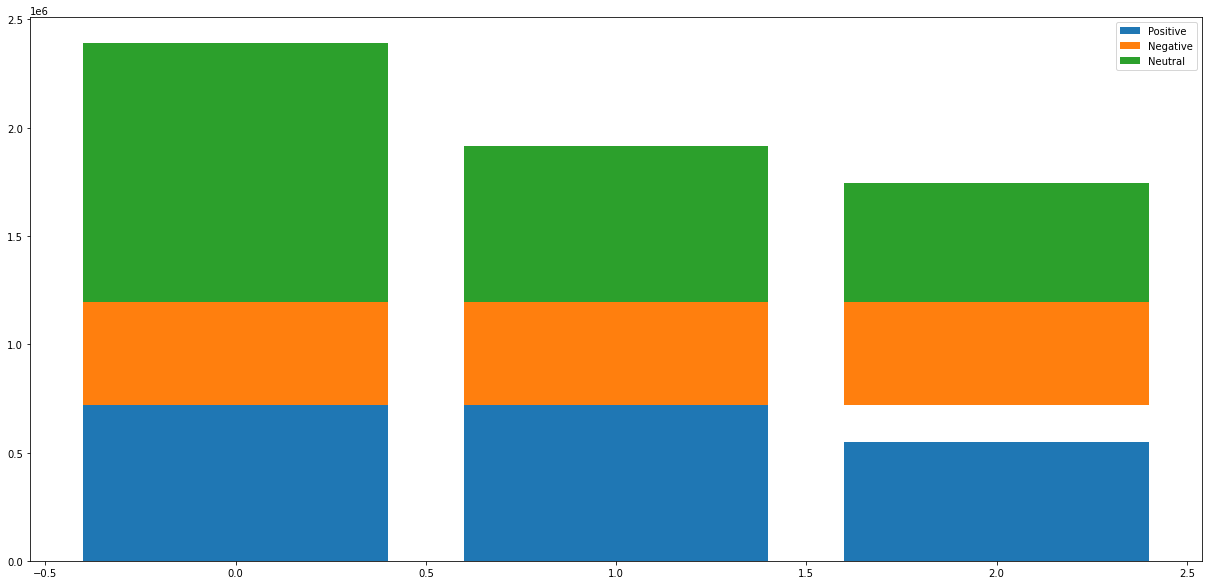

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(21,10))
position = np.arange(len(afinn_counts2021))
plt.bar(position, afinn_counts2021, label='Positive')
plt.bar(position, afinn_counts2021, label='Negative', bottom=afinn_counts2021.Positive)
plt.bar(position, afinn_counts2021, label='Neutral', bottom=afinn_counts2021.Negative)
plt.legend()
plt.show()

NameError: name 'textblob_counts2020' is not defined

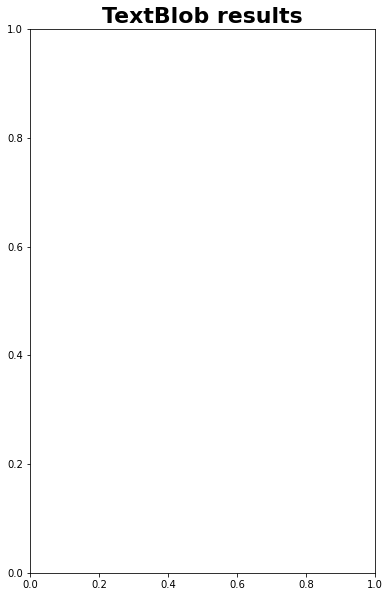

In [3]:
#dla roku 2020
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(21,10))
plt.subplot(1,3,1)
plt.title("TextBlob results", fontsize=22, fontweight="bold")
plt.bar(textblob_counts2020.values, labels = textblob_counts2020.index, explode = (0, 0, 0.25), autopct='%1.1f%%', textprops={'fontsize': 20}, shadow = False)
plt.subplot(1,3,2)
plt.title("VADER results", fontsize=22, fontweight="bold")
plt.bar(vader_counts2020.values, labels = vader_counts2020.index, explode = (0, 0, 0.25), autopct='%1.1f%%', textprops={'fontsize': 20}, shadow = False)
plt.subplot(1,3,3)
plt.title("Afinn results", fontsize=22, fontweight="bold")
plt.bar(afinn_counts2020.values, labels = afinn_counts2020.index, explode = (0, 0, 0.25), autopct='%1.1f%%', textprops={'fontsize': 20}, shadow = False)
plt.savefig("porownanie2020.pdf")

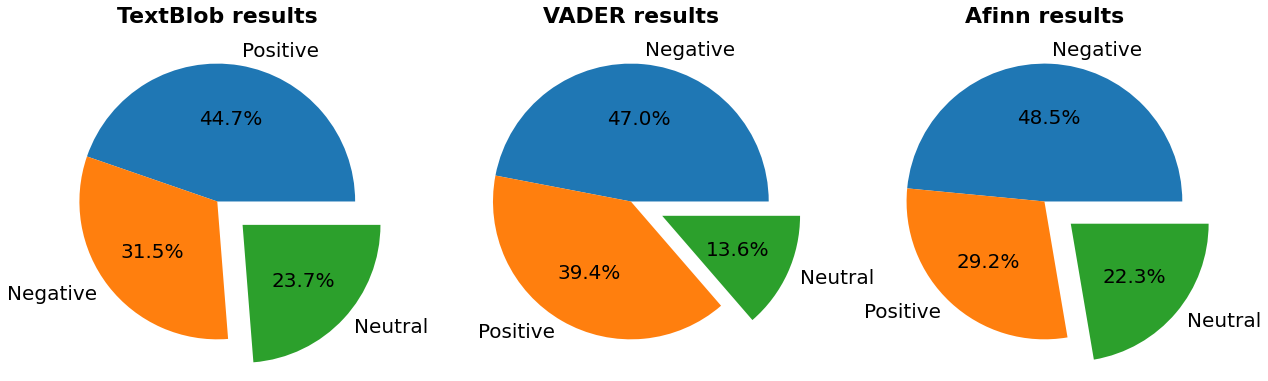

In [37]:
#dla roku 2021
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(21,10))
plt.subplot(1,3,1)
plt.title("TextBlob results", fontsize=22, fontweight="bold")
plt.pie(textblob_counts2021.values, labels = textblob_counts2021.index, explode = (0, 0, 0.25), autopct='%1.1f%%', textprops={'fontsize': 20}, shadow = False)
plt.subplot(1,3,2)
plt.title("VADER results", fontsize=22, fontweight="bold")
plt.pie(vader_counts2021.values, labels = vader_counts2021.index, explode = (0, 0, 0.25), autopct='%1.1f%%', textprops={'fontsize': 20}, shadow = False)
plt.subplot(1,3,3)
plt.title("Afinn results", fontsize=22, fontweight="bold")
plt.pie(afinn_counts2021.values, labels = afinn_counts2021.index, explode = (0, 0, 0.25), autopct='%1.1f%%', textprops={'fontsize': 20}, shadow = False)
plt.savefig("porownanie2021.pdf")

In [38]:
tweet2020.to_csv('tweets-2020-analiza.csv', sep=',', encoding='utf-8', index=False)
tweet2021.to_csv('tweets-2021-analiza.csv', sep=',', encoding='utf-8', index=False)

In [58]:
tweet = "97% of everyone in the hospitals who have covid are unvaccinated.  If you don't trust the medical field to prevent you from getting the virus, why do you trust them to cure you of it?  #stopthemadness  #mindboggling"

In [59]:
tweet_clean = clean(tweet)
tweet_clean

"    of everyone in the hospitals who have covid are unvaccinated   if you don't trust the medical field to prevent you from getting the virus  why do you trust them to cure you of it    stopthemadness   mindboggling"

In [60]:
tweet_split = tweet_clean.split()
tweet_split

['of',
 'everyone',
 'in',
 'the',
 'hospitals',
 'who',
 'have',
 'covid',
 'are',
 'unvaccinated',
 'if',
 'you',
 "don't",
 'trust',
 'the',
 'medical',
 'field',
 'to',
 'prevent',
 'you',
 'from',
 'getting',
 'the',
 'virus',
 'why',
 'do',
 'you',
 'trust',
 'them',
 'to',
 'cure',
 'you',
 'of',
 'it',
 'stopthemadness',
 'mindboggling']

In [61]:
tweet_tag = tag_stop_pos(tweet_split)
tweet_tag

[('everyone', 'n'),
 ('hospitals', 'n'),
 ('covid', 'v'),
 ('unvaccinated', 'a'),
 ('trust', 'v'),
 ('medical', 'a'),
 ('field', 'n'),
 ('prevent', 'v'),
 ('getting', 'v'),
 ('virus', 'n'),
 ('trust', 'v'),
 ('cure', 'v'),
 ('stopthemadness', 'v'),
 ('mindboggling', 'v')]

In [62]:
tweet_lemmatize = lemmatize(tweet_tag)
tweet_lemmatize

'  everyone hospital covid unvaccinated trust medical field prevent get virus trust cure stopthemadness mindboggling'

In [63]:
tweet_TextBlob_polartiy = TextBlob_Polarity(tweet_lemmatize)
tweet_TextBlob_polartiy

0.0

In [64]:
TextBlob_analysis(tweet_TextBlob_polartiy)

'Neutral'

In [65]:
tweet_Afinn_Sentiment = af.score(tweet_lemmatize)
tweet_Afinn_Sentiment

1.0

In [66]:
tweet_Afinn_analysis = Afinn_analysis(tweet_Afinn_Sentiment)
tweet_Afinn_analysis

'Positive'

In [67]:
tweet_vader_Sentiment = vader_Sentiment(tweet_lemmatize)
tweet_vader_Sentiment

0.7717

In [68]:
vader_Analysis(tweet_vader_Sentiment)

'Positive'